In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from touschek.touschek import get_LamTska, get_Touschek_Lifetime_Lebedev,\
                                get_Touschek_Lifetime_Valishev
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
from lattice import lattice
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))

In [2]:
ex = 5.82e-5*1e4
ey = 0.0037*ex
sz = 33.8
Ibeam = 3.185
V0 = 354
sp = 2.996e-4

In [5]:
ldf = lattice_df
aperture_factor=1
mldf = ldf.copy()
mldf['Beta_cm_X'] = np.where(mldf['S_cm']>2000, 200, 100)
mldf['Beta_cm_Y'] = np.where(mldf['S_cm']>2000, 100, 200)
mldf['Alpha_X'] = 0
mldf['Alpha_Y'] = 0
mldf['Dispersion_cm_X'] = 0
mldf['dDx'] = 0
mldf['dDx/dS'] = 0
mldf['Phi_X'] = 0
mldf['H'] = 0
dict_Leb = {}
leb = get_Touschek_Lifetime_Lebedev(mldf, V0, 1e-10, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Leb)
dict_Val = {}
val = get_Touschek_Lifetime_Valishev(mldf, V0, 0, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Val)
print("Lifetime (Leb) = ", leb)
print("Lifetime (Val) = ", val)
leb/val

Lifetime (Leb) =  106.11165867280218
Lifetime (Val) =  106.95255610108771


0.9921376593609343

In [5]:
2*np.pi

6.283185307179586

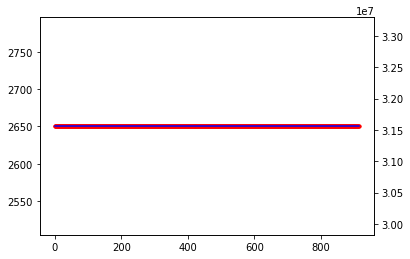

In [4]:
fig, ax = plt.subplots()
ax.plot(dict_Leb['Itski'], '.', color='red')
ax1 = ax.twinx()
ax1.plot(dict_Val['dN'], '-', color='blue')

In [18]:
from scipy import interpolate
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from lattice import lattice
from scipy import integrate
from scipy.special import iv



def ExI0(a, b):
    if b < 40:
        return np.exp(-a)*iv(0, b)
    else:
        return np.exp(-a+b)/np.sqrt(2*np.pi*b)\
            * (1+1/8/b+9/128/b**2+9*25/6/8**3/b**3)
    
# def ExI0(a, b):
#     return np.exp(-a)*iv(0, b)

    


def Ku(u, um, B1, B2):
    return np.sqrt(u/(1+u))*ExI0(B1*u, B2*u)\
        * ((2+1/u)**2*(u/um/(1+u)-1)+1-np.sqrt(um*(1+u)/u)
           - 1/2/u*(4+1/u)*np.log(u/um/(1+u)))


def Itsk(um, B1, B2):
    return integrate.quad(lambda u: Ku(u, um, B1, B2), um, np.inf)

gamma0 = get_from_config("gamma")
e = get_from_config("e")
c = get_from_config("c_m/s")*100
me = get_from_config("me_MeV")*1e6
alpha = get_from_config("ring_alpha")
q = get_from_config("RF_q")
VSR = get_from_config("VSR")
f0 = 1/get_from_config("IOTA_revolution_period")
fRF = q*f0
lamRF = c/fRF


re = 2.817941e-13  # cm




In [38]:
lattice_df = mldf
Vrf = V0
sp = 1e-10
aperture_factor=1.0
gamma=gamma0
test_dict=None
V0 = Vrf
ldf = lattice_df
etas = alpha-1/gamma**2
Ks = (alpha*gamma**2-1)/(gamma**2-1)
phiacc = np.arcsin(VSR/V0)
nus0 = np.sqrt(q*V0*np.abs(Ks)/2/np.pi/me/gamma)
nus = nus0*np.sqrt(np.cos(phiacc))
fs = f0*nus
dP_Psep = aperture_factor*2*nus0/q/np.abs(etas)*np.sqrt(np.cos(phiacc)
                                        - (np.pi/2-phiacc)*np.sin(phiacc))
Gs = lamRF/2/np.pi*q/nus*np.abs(etas)


ldf['Sigma_um_X'] = lattice.get_sigma_um(ldf['Beta_cm_X'], ex,
                                        ldf['Dispersion_cm_X'], sp)


aux1 = ldf['Beta_cm_X']/ex/1e-4/(
        1+(sp*ldf['Beta_cm_X']*ldf["Phi_X"]/ldf["Sigma_um_X"]/1e-4)**2)

aux2 = ldf['Beta_cm_Y']/ey/1e-4

B1 = 1/2/gamma**2*np.abs(aux1 + aux2)*2
B2 = 1/2/gamma**2*np.abs(aux1 - aux2)*2

S33 = 1/sp**2 + ldf['H']/ex/1e-4

Ne = Ibeam*1e-3/f0/e

um = dP_Psep**2
Itski = np.array([Itsk(um, b1, b2)[0] for b1, b2 in zip(B1, B2)])

sum_components = Itski/np.sqrt(S33)*ldf['dS']/(1/f0)
LamTska = Ne*re**2/(8*np.sqrt(np.pi)*gamma**4*ex*1e-4*ey*1e-4*sz*sp)\
    * sum_components.sum()

if test_dict is not None:
    test_dict['Itski'] = Itski

idx = 0
upper = 30
us = np.linspace(um, upper*um, 100)
Kus = np.array([Ku(u, um, B1[idx], B2[idx]) for u in us])
1/LamTska

498.90509569577137

In [39]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})

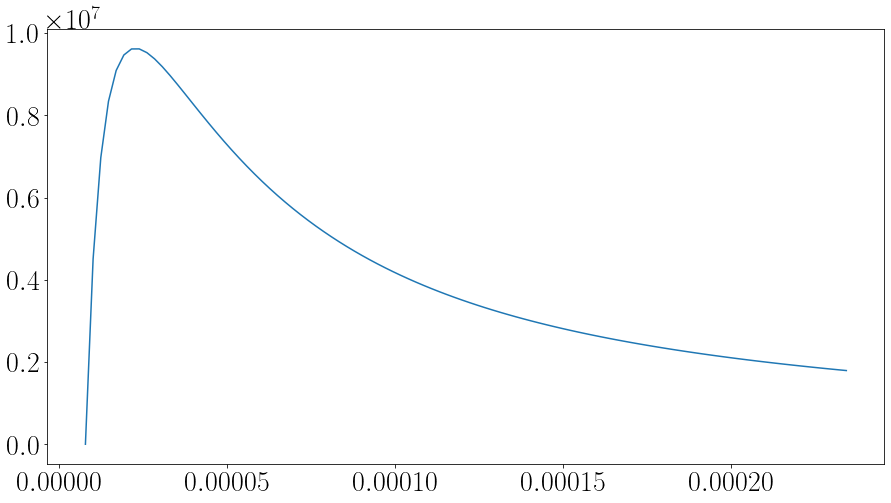

In [40]:
fig, ax = plt.subplots()
ax.plot(us, Kus)

In [48]:
lattice_df = mldf
Vrf = V0
sp = 1e-10
aperture_factor=1.0
gamma=gamma0
test_dict=None
V0 = Vrf
ldf = lattice_df
V0 = Vrf
integration_upper_lim_rel=30
test_dict=None
etas = alpha-1/gamma**2
Ks = (alpha*gamma**2-1)/(gamma**2-1)
phiacc = np.arcsin(VSR/V0)
nus0 = np.sqrt(q*V0*np.abs(Ks)/2/np.pi/me/gamma)
nus = nus0*np.sqrt(np.cos(phiacc))
fs = f0*nus
dP_Psep = aperture_factor*2*nus0/q/np.abs(etas)*np.sqrt(np.cos(phiacc)
                                        - (np.pi/2-phiacc)*np.sin(phiacc))
eta = dP_Psep
Ne = Ibeam*1e-3/f0/e

NN = len(ldf.index)
M = np.zeros(shape=(NN, 5, 5))
M[:,3,1] = np.sqrt(ldf['Beta_cm_X'])
M[:,2,1] = ldf['Alpha_X']/np.sqrt(ldf['Beta_cm_X'])
M[:,2,2] = 1/np.sqrt(ldf['Beta_cm_X'])
M[:,1,3] = np.sqrt(ldf['Beta_cm_Y'])
M[:,0,3] = ldf['Alpha_Y']/np.sqrt(ldf['Beta_cm_Y'])
M[:,0,4] = 1/np.sqrt(ldf['Beta_cm_Y'])

e1, e2 = 1e-4*ex, 1e-4*ey

Axx = (M[:, 2, 1]**2+M[:, 2, 2]**2)/2/e1+(M[:, 2, 3]**2+M[:, 2, 4]**2)/2/e2
Ayy = (M[:, 0, 1]**2+M[:, 0, 2]**2)/2/e1+(M[:, 0, 3]**2+M[:, 0, 4]**2)/2/e2
Apxpx = (M[:, 3, 1]**2+M[:, 3, 2]**2)/2/e1+(M[:, 3, 3]**2+M[:, 3, 4]**2)/2/e2
Apypy = (M[:, 1, 1]**2+M[:, 1, 2]**2)/2/e1+(M[:, 1, 3]**2+M[:, 1, 4]**2)/2/e2
Axpx = -2*((M[:, 3, 1]*M[:, 2, 1]+M[:, 3, 2]*M[:, 2, 2])/2/e1
        + (M[:, 3, 3]*M[:, 2, 3]+M[:, 3, 4]*M[:, 2, 4])/2/e2)
Aypy = -2*((M[:, 1, 1]*M[:, 0, 1]+M[:, 1, 2]*M[:, 0, 2])/2/e1
        + (M[:, 1, 3]*M[:, 0, 3]+M[:, 1, 4]*M[:, 0, 4])/2/e2)
Axy = 2*((M[:, 2, 1]*M[:, 0, 1]+M[:, 2, 2]*M[:, 0, 2])/2/e1
        + (M[:, 2, 3]*M[:, 0, 3]+M[:, 2, 4]*M[:, 0, 4])/2/e2)
Apxpy = 2*((M[:, 3, 1]*M[:, 1, 1]+M[:, 3, 2]*M[:, 1, 2])/2/e1
        + (M[:, 3, 3]*M[:, 1, 3]+M[:, 3, 4]*M[:, 1, 4])/2/e2)
Axpy = -2*((M[:, 2, 1]*M[:, 1, 1]+M[:, 2, 2]*M[:, 1, 2])/2/e1
        + (M[:, 2, 3]*M[:, 1, 3]+M[:, 2, 4]*M[:, 1, 4])/2/e2)
Aypx = -2*((M[:, 3, 1]*M[:, 0, 1]+M[:, 3, 2]*M[:, 0, 2])/2/e1
        + (M[:, 3, 3]*M[:, 0, 3]+M[:, 3, 4]*M[:, 0, 4])/2/e2)

Fx = Apxpx-Axpx**2/4/Axx-1/4*(Aypx-Axpx*Axy/2/Axx)**2/(Ayy-Axy**2/4/Axx)
Fy = Apypy-Axpy**2/4/Axx-1/4*(Aypy-Axpy*Axy/2/Axx)**2/(Ayy-Axy**2/4/Axx)
Fpx = Axx - Axpx**2/4/Apxpx-1/4*(Axpy-Axpx*Apxpy/2/Apxpx)**2\
    / (Apypy-Apxpy**2/4/Apxpx)
Fpy = Ayy-Aypx**2/4/Apxpx-1/4*(Aypy-Aypx*Apxpy/2/Apxpx)**2\
    / (Apypy-Apxpy**2/4/Apxpx)
Fxy = Apxpy/2-Axpx*Axpy/2/Axx-1/4*(Aypx-Axpx*Axy/2/Axx)*(Aypy-Axpy*Axy/2/Axx)\
    / (Ayy-Axy**2/4/Axx)
Fpxpy = Axy/2-Axpx*Aypx/4/Apxpx-1/4*(Aypy-Aypx*Apxpy/2/Apxpx)\
    * (Axpy-Axpx*Apxpy/2/Apxpx)/(Apypy-Apxpy**2/4/Apxpx)

def Pfunc(k):
    Axxk, Ayyk, Axyk, Fxk, Fyk, Fxyk = \
        Axx[k], Ayy[k], Axy[k], Fx[k], Fy[k], Fxy[k]

    def func(Q):
        return 1/8/e1**2/e2**2/(Axxk*Ayyk-1/4*Axyk**2)\
            / np.sqrt(Fxk*Fyk-Fxyk**2)*np.exp(-Q**2*(Fxk/2+Fyk/2))\
            * iv(0, Q**2*np.sqrt(1/4*(Fyk-Fxk)**2+Fxyk**2))*Q
    return func

def s0(q):
    aux1 = re**2*(1+2*q**2)**2*np.pi**2/2/q**4/(1+q**2)
    aux2 = q**2/(1+q**2)*(1/eta**2)-1+np.log(np.sqrt(1+q**2)/q*eta)
    aux3 = (q**2/(1+2*q**2))**2*(1-eta*np.sqrt(1+q**2)/q
                                - 4*np.log(eta*np.sqrt(1+q**2)/q))
    return aux1*(aux2+aux3)

qm = eta/np.sqrt(1-eta**2)

def integrand(k):
    Pf = Pfunc(k)

    def res(Q):
        return Q/2*np.sqrt(1+(Q/2)**2)*s0(Q/2)*Pf(Q/gamma)
    return res

B = []
upper_lim_coef = integration_upper_lim_rel
for k in ldf.index:
    upper_limit = gamma/np.sqrt(Fx[k]+Fy[k])*upper_lim_coef
    f_int = integrand(k)
    B.append(integrate.quad(f_int, 2*qm, upper_limit)[0])
B = np.array(B)

dN = 2*c/gamma**3*Ne**2/(64*np.pi**(3/2)*e1**2*e2**2*sz)\
    / (Apypy*Apxpx-1/4*Apxpy**2)\
    / np.sqrt(Fpx*Fpy-Fpxpy**2) * B

DN = (dN*ldf['dS']).sum()/ldf['dS'].sum()
tau = Ne/DN
if test_dict is not None:
    test_dict['dN'] = dN
tau

79.62611592903716

In [42]:
f = integrand(idx)
k=idx
Axxk, Ayyk, Axyk, Fxk, Fyk, Fxyk = \
        Axx[k], Ayy[k], Axy[k], Fx[k], Fy[k], Fxy[k]
Kus_Val = np.array([f(2*np.sqrt(u))/np.sqrt(u) for u in us])\
        /(1/8/e1**2/e2**2/(Axxk*Ayyk-1/4*Axyk**2)\
            / np.sqrt(Fxk*Fyk-Fxyk**2))/re**2

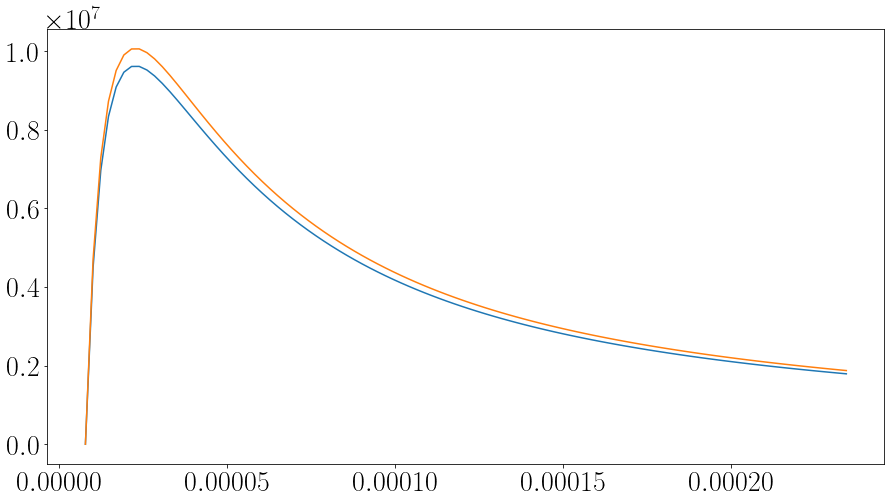

In [50]:
fig, ax = plt.subplots()
ax.plot(us, Kus)
ax.plot(us, 20*Kus_Val)

In [44]:
f = Pfunc(idx)
Ps = np.array([ExI0(B1[idx]*u, B2[idx]*u) for u in us])
Ps_Val = np.array([f(np.sqrt(2*u)/gamma)*gamma/np.sqrt(2*u) for u in us])\
        /(1/8/e1**2/e2**2/(Axxk*Ayyk-1/4*Axyk**2)\
            / np.sqrt(Fxk*Fyk-Fxyk**2))

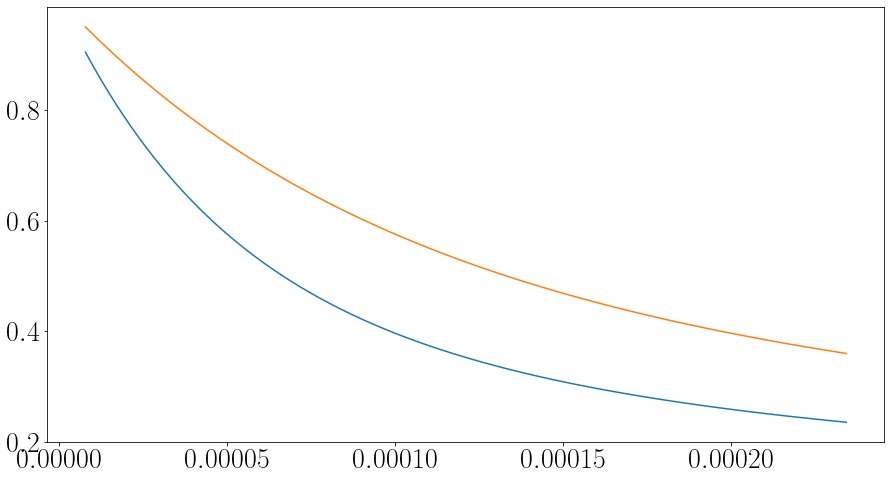

In [45]:
fig, ax = plt.subplots()
ax.plot(us, Ps)
ax.plot(us, Ps_Val)

In [14]:
B1[idx]

6548.4264231993775

In [15]:
B2[idx]

6500.146702633795

In [16]:
(Fxk/2+Fyk/2)*4/gamma**2

13096.852846398755